In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_sales = pd.read_csv('all_orders.csv')
df_sales.head()

,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,PROD_ID,ORDER_QTY
0,357775,40,Y,20,New Zealand,201941,P000517,1
1,370120,20,Y,10,New Zealand,201941,P000254,2
2,382465,30,Y,20,New Zealand,201941,P000218,1
3,394810,60,Y,40,New Zealand,201940,P000518,1
4,407155,20,Y,10,New Zealand,201941,P000230,1


In [3]:
# df_sales.info()
df_sales.describe()

,ORDER_ID,ORDER_ITEM_NR,COMBO_ITEM_NR,FISCAL_WEEK,ORDER_QTY
count,3.023720e+05,302372.000000,302372.000000,302372.000000,302372.000000
mean,1.127251e+09,26.042921,10.169625,201868.118761,1.758886
std,6.886566e+08,21.814909,18.587063,64.218335,0.836050
min,3.577750e+05,10.000000,0.000000,201746.000000,1.000000
25%,5.283997e+08,20.000000,0.000000,201811.000000,1.000000
50%,1.092977e+09,30.000000,10.000000,201902.000000,2.000000
75%,1.703412e+09,30.000000,10.000000,201914.000000,2.000000
max,2.433199e+09,960.000000,940.000000,202003.000000,4.000000


In [4]:
df_attribute= pd.read_csv('product_attribute.csv')
df_attribute.columns

Index(['PROD_ID', 'PRODUCT_TYPE', 'PRODUCT_VERSION', 'MATERIAL_DESC',
       'MATERIAL_COLOR', 'CONNECTIVITY'],
      dtype='object')

In [5]:
# df_sales['PROD_ID'].value_counts()
# df_sales['FISCAL_WEEK'].value_counts()
# df_attribute['PROD_ID']

In [6]:
# see the distribution of quantity in sales data

def count_values_sales(quantity):
    return df_sales[quantity].value_counts()

quantity= 'ORDER_ITEM_NR'
print(count_values_sales(quantity))

ORDER_ITEM_NR
30     122908
20      86485
10      59852
40      17423
50       6705
        ...  
950         1
920         1
580         1
700         1
730         1
Name: count, Length: 86, dtype: int64


In [7]:
merged_df = pd.merge(df_sales, df_attribute, on= 'PROD_ID', how='inner')

In [8]:
merged_df.to_csv('Merged_df.csv')

In [9]:
product_sales_ts = merged_df.groupby(['PROD_ID', 'FISCAL_WEEK']).sum()

In [12]:
from datetime import timedelta
df_time= pd.read_csv('fiscal_calendar.csv')
df_time.columns

Index(['FISCAL_WEEK', 'FISCAL_YEAR', 'MONTH', 'WEEK_IN_QUARTER',
       'WEEK_IN_MONTH'],
      dtype='object')

In [15]:
# Function to calculate the week's starting date
def get_week_start_date(year, month, week_in_month):
    month_start = pd.Timestamp(year=year, month=month, day=1)
    # Convert to Python native int type
    week_offset = int(week_in_month) - 1
    week_start = month_start + timedelta(weeks=week_offset)
    return week_start

# Iterate over the DataFrame rows
week_start_dates = []
for index, row in df_time.iterrows():
    week_start_date = get_week_start_date(row['FISCAL_YEAR'], row['MONTH'], row['WEEK_IN_MONTH'])
    week_start_dates.append(week_start_date)

# Add the calculated dates as a new column
df_time['WEEK_START_DATE'] = week_start_dates

df_time.head()

,FISCAL_WEEK,FISCAL_YEAR,MONTH,WEEK_IN_QUARTER,WEEK_IN_MONTH,WEEK_START_DATE
0,201833,2018,8,7,2,2018-08-08
1,201902,2019,1,2,2,2019-01-08
2,202027,2020,6,13,4,2020-06-22
3,201803,2018,1,3,3,2018-01-15
4,201618,2016,4,5,5,2016-04-29


In [17]:
df_old= pd.read_csv('Merged_df.csv')
df_merged = pd.merge(df_old, df_time, on='FISCAL_WEEK', how='left')
df_merged.head()

,Unnamed: 0,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,PROD_ID,ORDER_QTY,PRODUCT_TYPE,PRODUCT_VERSION,MATERIAL_DESC,MATERIAL_COLOR,CONNECTIVITY,FISCAL_YEAR,MONTH,WEEK_IN_QUARTER,WEEK_IN_MONTH,WEEK_START_DATE
0,0,357775,40,Y,20,New Zealand,201941,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,10,2,2,2019-10-08
1,1,15863095,30,Y,10,New Zealand,201930,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,4,4,2019-07-22
2,2,17184010,30,Y,10,Macao,201948,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,11,9,4,2019-11-22
3,3,34911430,30,Y,10,New Zealand,201930,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,4,4,2019-07-22
4,4,34973155,30,Y,10,New Zealand,201931,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,5,5,2019-07-29


In [21]:

# Plotting time series data for each product
for product_id in df_merged['PRODUCT_TYPE'].unique():
    product_data = product_sales_ts.xs(product_id, level='PRODUCT_TYPE')
    plt.plot(product_data.index, product_data['ORDER_QTY'], marker='o', label=product_id)

plt.xlabel('Sale Date')
plt.ylabel('Sales')
plt.title('Product-wise Time Series of Sales')
plt.legend()
plt.show()

KeyError: 'Level PRODUCT_TYPE not found'

In [97]:
# Summarize total sales for each product
total_sales_per_product = df.groupby('PROD_ID')['ORDER_QTY'].sum()


In [98]:
# Identify the top five products with the highest sales
top_five_products = total_sales_per_product.nlargest(5).index

# Filter the DataFrame to include only these top five products
top_products_df = df[df['PROD_ID'].isin(top_five_products)]
top_products_df

,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,PROD_ID,ORDER_QTY
23,641710,30,Y,10,New Zealand,201815,P000704,2
59,1086130,30,Y,10,New Zealand,201751,P000705,1
72,1246615,30,Y,10,Macao,201932,P000268,1
81,1357720,30,Y,10,Macao,201906,P000275,2
82,1370065,30,Y,10,Macao,201905,P000268,1
...,...,...,...,...,...,...,...,...
302098,2431310485,30,Y,10,New Zealand,201911,P000267,2
302217,2431754905,10,N,0,New Zealand,201904,P000268,1
302218,2431767250,10,N,0,Macao,201907,P000268,4
302219,2431779595,10,N,0,New Zealand,201952,P000268,3


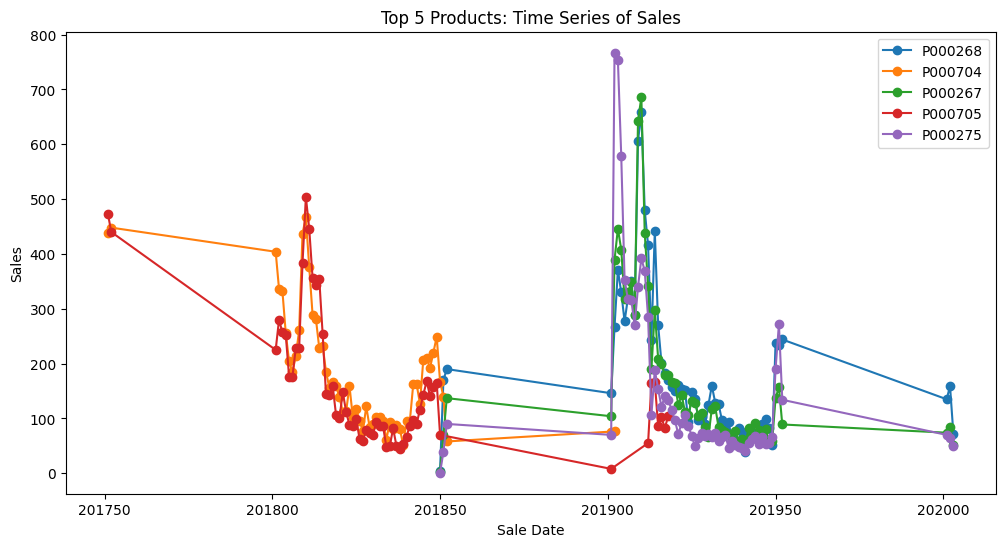

In [100]:
# Plotting
plt.figure(figsize=(12, 6))
for product_id in top_five_products:
    product_data = product_sales_ts.xs(product_id, level='PROD_ID')
    plt.plot(product_data.index, product_data['ORDER_QTY'], marker='o', label=product_id)

plt.xlabel('Sale Date')
plt.ylabel('Sales')
plt.title('Top 5 Products: Time Series of Sales')
plt.legend()
plt.show()

In [101]:
merged_df['FISCAL_WEEK'] = pd.to_datetime(merged_df['FISCAL_WEEK']).dt.isocalendar().week

In [104]:
merged_df['FISCAL_WEEK'].unique()

<IntegerArray>
[1]
Length: 1, dtype: UInt32

In [103]:
merged_df.head()

,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,PROD_ID,ORDER_QTY,PRODUCT_TYPE,PRODUCT_VERSION,MATERIAL_DESC,MATERIAL_COLOR,CONNECTIVITY
0,357775,40,Y,20,New Zealand,1,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN
1,15863095,30,Y,10,New Zealand,1,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN
2,17184010,30,Y,10,Macao,1,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN
3,34911430,30,Y,10,New Zealand,1,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN
4,34973155,30,Y,10,New Zealand,1,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN


In [131]:
from datetime import timedelta
df_time= pd.read_csv('fiscal_calendar.csv')
df_time.columns

Index(['FISCAL_WEEK', 'FISCAL_YEAR', 'MONTH', 'WEEK_IN_QUARTER',
       'WEEK_IN_MONTH'],
      dtype='object')

In [132]:
# Function to calculate the week's starting date
def get_week_start_date(year, month, week_in_month):
    month_start = pd.Timestamp(year=year, month=month, day=1)
    # Convert to Python native int type
    week_offset = int(week_in_month) - 1
    week_start = month_start + timedelta(weeks=week_offset)
    return week_start

# Iterate over the DataFrame rows
week_start_dates = []
for index, row in df_time.iterrows():
    week_start_date = get_week_start_date(row['FISCAL_YEAR'], row['MONTH'], row['WEEK_IN_MONTH'])
    week_start_dates.append(week_start_date)

# Add the calculated dates as a new column
df_time['WEEK_START_DATE'] = week_start_dates

# print(df_time)

     FISCAL_WEEK  FISCAL_YEAR  MONTH  WEEK_IN_QUARTER  WEEK_IN_MONTH  \
0         201833         2018      8                7              2   
1         201902         2019      1                2              2   
2         202027         2020      6               13              4   
3         201803         2018      1                3              3   
4         201618         2016      4                5              5   
..           ...          ...    ...              ...            ...   
256       201825         2018      6               12              3   
257       201608         2016      2                8              3   
258       201918         2019      4                5              5   
259       201811         2018      3               11              2   
260       201947         2019     11                8              3   

    WEEK_START_DATE  
0        2018-08-08  
1        2019-01-08  
2        2020-06-22  
3        2018-01-15  
4        2016-04-29  
.. 

In [152]:
df_old= pd.read_csv('Merged_df.csv')
df_merged = pd.merge(df_old, df_time, on='FISCAL_WEEK', how='left')
df_merged.head()

,Unnamed: 0,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,PROD_ID,ORDER_QTY,PRODUCT_TYPE,PRODUCT_VERSION,MATERIAL_DESC,MATERIAL_COLOR,CONNECTIVITY,FISCAL_YEAR,MONTH,WEEK_IN_QUARTER,WEEK_IN_MONTH,WEEK_START_DATE
0,0,357775,40,Y,20,New Zealand,201941,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,10,2,2,2019-10-08
1,1,15863095,30,Y,10,New Zealand,201930,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,4,4,2019-07-22
2,2,17184010,30,Y,10,Macao,201948,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,11,9,4,2019-11-22
3,3,34911430,30,Y,10,New Zealand,201930,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,4,4,2019-07-22
4,4,34973155,30,Y,10,New Zealand,201931,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,5,5,2019-07-29


In [153]:
product_sales_ts = df_merged.groupby(['PROD_ID', 'WEEK_START_DATE']).sum()   

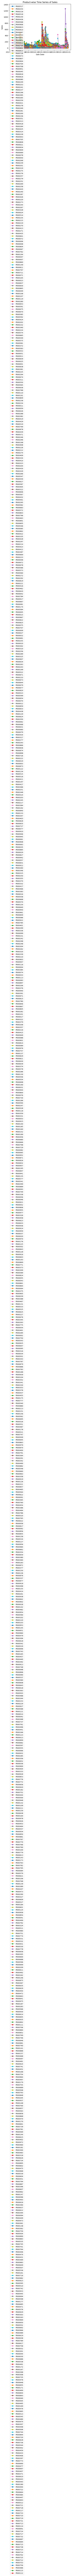

In [154]:
import matplotlib.pyplot as plt

# Plotting time series data for each product
for product_id in df_merged['PROD_ID'].unique():
    product_data = product_sales_ts.xs(product_id, level='PROD_ID')
    plt.plot(product_data.index, product_data['ORDER_QTY'], marker='o', label=product_id)

plt.xlabel('Sale Date')
plt.ylabel('Sales')
plt.title('Product-wise Time Series of Sales')
plt.legend()
plt.show()

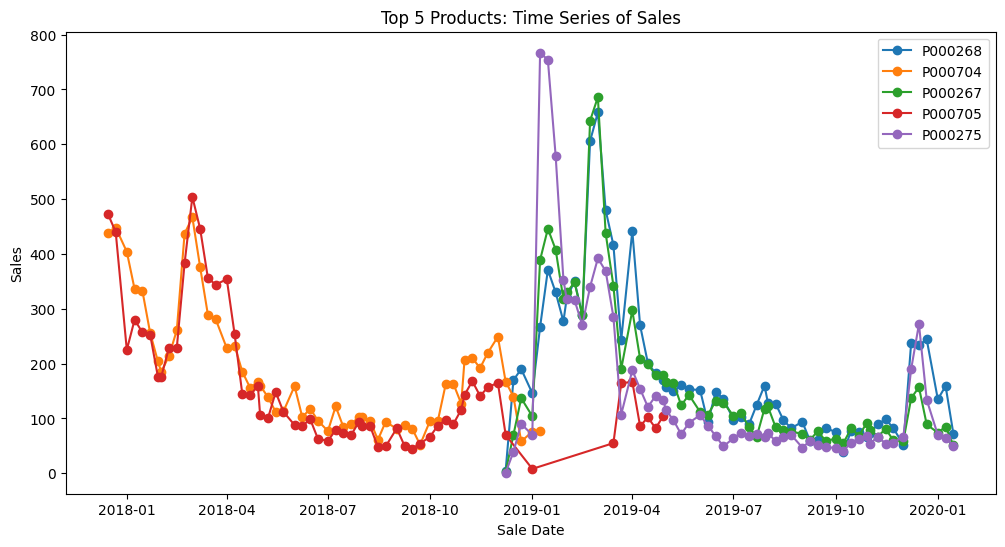

In [155]:
# Plotting
plt.figure(figsize=(12, 6))
for product_id in top_five_products:
    product_data = product_sales_ts.xs(product_id, level='PROD_ID')
    plt.plot(product_data.index, product_data['ORDER_QTY'], marker='o', label=product_id)

plt.xlabel('Sale Date')
plt.ylabel('Sales')
plt.title('Top 5 Products: Time Series of Sales')
plt.legend()
plt.show()

In [156]:
import tsfresh as tsf

ModuleNotFoundError: No module named 'tsfresh'